# <font color='blue'>Data Science Academy - Deep Learning I</font>
# Classificação de Imagens e Transfer Learning

## Identificação de Imagens de Cães

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


### Introdução

Neste Jupyter Notebook, você dará os primeiros passos para o desenvolvimento de um algoritmo de Inteligência Artificial que pode ser usado como parte de um aplicativo móvel ou web. Ao final, seu código aceitará qualquer imagem fornecida pelo usuário como entrada. Se um cão for detectado na imagem, o algoritmo fornecerá uma estimativa da raça do cão. Se um ser humano for detectado, fornecerá uma estimativa da raça do cão, que mais se parace com humano (apenas para que possamos nos divertir um pouco). Caso não seja possível detectar nem um cão nem um humano, o algoritmo irá nos informar!

Neste contexto do mundo real, você precisará reunir uma série de modelos para executar tarefas diferentes. Por exemplo, o algoritmo que detecta seres humanos em uma imagem será diferente da CNN que infere a raça de cães. Existem muitos pontos de possível falha, e não existe um algoritmo perfeito. Seu objetivo aqui é aprender sobre classificação de imagens usando Deep Learning. Também usaremos o OpenCV para nos auxiliar na detecção de imagens.

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Carregando os dados
* [Etapa 2](#etapa2): Detectando Humanos
* [Etapa 3](#etapa3): Detectando Cães
* [Etapa 4](#etapa4): Criando um Modelo CNN Para Classificar Cães
* [Etapa 5](#etapa5): Usando um Modelo CNN Para Classificar Cães (com Transfer Learning)
* [Etapa 6](#etapa6): Criando um Modelo CNN Para Classificar Cães (usando Transfer Learning)
* [Etapa 7](#etapa7): Criando Aplicação Para Classificação de Imagens
* [Etapa 8](#etapa8): Testando o Modelo


In [2]:
# Certifique-se que a GPU tem memória disponível
!nvidia-smi

Sun May  3 16:42:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   37C    P8     9W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Instala o keras_tqdm
!pip install -q keras_tqdm

In [5]:
# Imports
import sklearn
import keras
import tensorflow as tf
import numpy as np
from glob import glob
from sklearn.datasets import load_files       
from keras.utils import np_utils

Using TensorFlow backend.


In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy      1.18.2
sklearn    0.22.2
tensorflow 2.1.0
keras      2.3.1
Data Science Academy


<a id = 'etapa1'></a>
## Etapa 1: Carregando os dados

Este dataset foi extraído do site de Visão Computacional da Universidade de Stanford: http://vision.stanford.edu/aditya86/ImageNetDogs/. O dataset possui quase 1 GB e nós já baixamos e disponibilizamos para você no servidor da DSA em: /media/datasets/DeepLearningI/Cap08. O arquivo zip está disponível caso você queira copiar para sua máquina usando algum cliente SFTP.

In [7]:
# Função para carregar os dados de treino, validação e teste
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Carregando os dados (input e output)
train_files, train_targets = load_dataset('/media/datasets/DeepLearningI/Cap09/dogImages/train')
valid_files, valid_targets = load_dataset('/media/datasets/DeepLearningI/Cap09/dogImages/valid')
test_files, test_targets = load_dataset('/media/datasets/DeepLearningI/Cap09/dogImages/test')

# Lista com os nomes das raças de cães
dog_names = [item[56:-1] for item in glob('/media/datasets/DeepLearningI/Cap09/dogImages/train/*/')]

# Resumo do dataset
print('Existem %d categorias de cães.' % len(dog_names))
print('Existem %s imagens de cães.' % len(np.hstack([train_files, valid_files, test_files])))
print('Existem %d imagens de cães no dataset de treino.' % len(train_files))
print('Existem %d imagens de cães no dataset de validação.' % len(valid_files))
print('Existem %d imagens de cães no dataset de teste.'% len(test_files))

Existem 133 categorias de cães.
Existem 8351 imagens de cães.
Existem 6680 imagens de cães no dataset de treino.
Existem 835 imagens de cães no dataset de validação.
Existem 836 imagens de cães no dataset de teste.


In [8]:
# Raças de cães
print(dog_names)

['Bedlington_terrier', 'Boston_terrier', 'Clumber_spaniel', 'Canaan_dog', 'Dogue_de_bordeaux', 'Lowchen', 'English_springer_spaniel', 'Labrador_retriever', 'German_pinscher', 'Yorkshire_terrier', 'Border_collie', 'Greater_swiss_mountain_dog', 'Finnish_spitz', 'Irish_terrier', 'Chinese_shar-pei', 'American_foxhound', 'Mastiff', 'Bull_terrier', 'American_water_spaniel', 'Old_english_sheepdog', 'Havanese', 'Smooth_fox_terrier', 'American_staffordshire_terrier', 'Newfoundland', 'German_shorthaired_pointer', 'German_shepherd_dog', 'Alaskan_malamute', 'Briard', 'Komondor', 'Kerry_blue_terrier', 'Bouvier_des_flandres', 'Pointer', 'French_bulldog', 'Great_pyrenees', 'Bluetick_coonhound', 'Lakeland_terrier', 'Brussels_griffon', 'Cardigan_welsh_corgi', 'Beauceron', 'Belgian_malinois', 'Gordon_setter', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Dandie_dinmont_terrier', 'Basenji', 'Miniature_schnauzer', 'Borzoi', 'German_wirehaired_pointer', 'English_cocker_spaniel', 'Norwegian_lundehund

Agora carregamos o dataset com fotos de humanos.

In [9]:
import random
random.seed(4356287)

# Carrega o nome dos arquivos de forma randomnizada (shuffle)
human_files = np.array(glob("/media/datasets/DeepLearningI/Cap09/humanImages/*/*"))
random.shuffle(human_files)

# Resumo
print('Existem %d imagens de humanos.' % len(human_files))

Existem 13233 imagens de humanos.


<a id='etapa2'></a>
## Etapa 2: Detectando Humanos

Usaremos a implementação do OpenCV chamada [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) para detectar faces humanas nas imagens.  O OpenCV oferece vários detectores de faces pré-treinados, armazenados como arquivos XML em [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). Já fizemos o download de um desses detectores e colocamos na pasta `haarcascades`. Vejamos agora como utilizá-lo.

Número de faces detectadas: 1


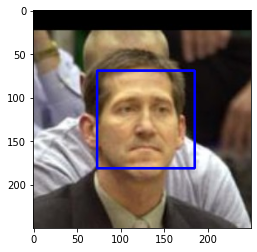

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# Extraindo o detector pré-treinado
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Carregando imagens BGR
img = cv2.imread(human_files[6])

# Convertendo para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Buscando faces nas imagens
faces = face_cascade.detectMultiScale(gray)

# Print do número de faces na imagem
print('Número de faces detectadas:', len(faces))

# Obter caixa delimitadora para cada face detectada
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Converte a imagem BGR em RGB para o plot
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display da imagem
plt.imshow(cv_rgb)
plt.show()

Antes de usar qualquer um dos detectores de face, é um procedimento padrão converter as imagens em escala de cinza. A função `detectMultiScale` executa o classificador armazenado em `face_cascade` e converte a imagem em escala de cinza como um parâmetro.

No código acima, `faces` é uma matriz numérica de faces detectadas, onde cada linha corresponde a uma face detectada. Cada face detectada é uma matriz 1D com quatro entradas que especificam a caixa delimitadora do rosto detectado. As duas primeiras entradas na matriz (extraídas no código acima como `x` e `y`) especificam as posições horizontal e vertical do canto superior esquerdo da caixa delimitadora. As duas últimas entradas na matriz (extraídas aqui como `w` e `h`) especificam a largura e a altura da caixa.

Podemos usar esse procedimento para escrever uma função que retorna `True` se um rosto humano for detectado em uma imagem e `False` caso contrário. Esta função, apropriadamente chamada `face_detector`, recebe um caminho de arquivo com valor de string para uma imagem como entrada e aparece no bloco de código abaixo.

In [11]:
# Retorna "True" se a face for detectada na imagem armazenada no img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Idealmente, gostaríamos que 100% das imagens humanas tivessem um rosto detectado e 0% de imagens de cães tivessem faces humanas detectadas. Isso é bem difícil de se obter, mas temos um desempenho aceitável no exemplo abaixo. Nós extraímos os caminhos dos arquivos para as primeiras 100 imagens de cada um dos conjuntos de dados e armazenamos nos arrays numpy `human_files_short` e `dog_files_short`.

In [12]:
# Analisando faces humanas em ambos os datasets
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

faces_count = 0
dog_count = 0
for path in human_files_short:
    if (face_detector(path)):
        faces_count += 1
for path in dog_files_short:
    if (face_detector(path)):
        dog_count += 1
print ("% de faces humanas detectadas no arquivo de fotos humanas: ",(faces_count/100)*100)
print ("% de faces humanas detectadas no arquivo de fotos cães: ",(dog_count/100)*100)

% de faces humanas detectadas no arquivo de fotos humanas:  100.0
% de faces humanas detectadas no arquivo de fotos cães:  12.0


<a id='etapa3'></a>
## Etapa 3: Detectando Cães

Usaremos um modelo pré-treinado [ResNet-50] (http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) para detectar cães em imagens. Nossa primeira linha de código faz o download do modelo ResNet-50, juntamente com pesos que foram treinados no [ImageNet] (http://www.image-net.org/), um conjunto de dados muito grande e muito popular usado para classificação de imagens e outras tarefas de visão computacional. O ImageNet contém mais de 10 milhões de URLs, cada um vinculando a uma imagem contendo um objeto de uma das 1000 categorias (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Dada uma imagem, este modelo ResNet-50 pré-treinado retorna uma previsão (derivada das categorias disponíveis no ImageNet) para o objeto que está contido na imagem.

In [13]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights = 'imagenet')
ResNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Pré-processamento

Ao usar o TensorFlow como backend, as CNNs do Keras exigem uma matriz 4D (que também nos referiremos como um tensor 4D) como entrada, na forma:

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

onde `nb_samples` corresponde ao número total de imagens (ou amostras), e `rows`, `columns` e `channels` correspondem ao número de linhas, colunas e canais para cada imagem, respectivamente.

A função `path_to_tensor` abaixo recebe um caminho de arquivo com valor de string para uma imagem colorida como entrada e retorna um tensor 4D adequado para uma entrada a uma CNN do Keras. A função primeiro carrega a imagem e redimensiona-a para uma imagem quadrada que é $ 224 \ x  \ 224 $ pixels. Em seguida, a imagem é convertida em uma matriz, que é redimensionada para um tensor 4D. Neste caso, uma vez que estamos trabalhando com imagens coloridas, cada imagem possui três canais. Da mesma forma, uma vez que estamos processando uma única imagem (ou amostra), o tensor retornado sempre terá a forma:
$$
(1, 224, 224, 3).
$$

A função `paths_to_tensor` recebe uma matriz numpy de caminhos de imagem com valores de cadeia como entrada e retorna um tensor 4D com forma

$$
(\text{nb_samples}, 224, 224, 3).
$$

Aqui, `nb_samples` é o número de amostras, ou número de imagens, na matriz fornecida de caminhos de imagem. É melhor pensar em `nb_samples` como o número de tensores 3D (onde cada tensor 3D corresponde a uma imagem diferente) em seu conjunto de dados!

In [14]:
# !pip install tqdm
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size = (224, 224))
    x = image.img_to_array(img)
    
    # Converte tensor 3D em tensor 4D na forma (1, 224, 224, 3) e retorna o tensor 4D
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Fazendo Previções com ResNet-50

Obter o tensor 4D pronto para ResNet-50, e para qualquer outro modelo pré-treinado em Keras, requer algum processamento adicional. Primeiro, a imagem RGB é convertida em BGR ao reordenar os canais. Todos os modelos pré-treinados têm o passo de normalização adicional que o pixel médio (expresso em RGB como $ [103.939, 116.779, 123.68] $ e calculado a partir de todos os pixels em todas as imagens no ImageNet) deve ser subtraído de cada pixel em cada imagem. Isso é implementado na função `preprocess_input`. Se você estiver curioso, você pode verificar o código para `preprocess_input` aqui: (https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Agora que temos uma maneira de formatar nossa imagem para fornecer a ResNet-50, estamos prontos para usar o modelo para extrair as previsões. Isso é realizado com o método `predict`, que retorna uma matriz cuja entrada $ i $ -th é a probabilidade prevista do modelo de que a imagem pertence à categoria $ i $ -th ImageNet. Isso é implementado na função `ResNet50_predict_labels` abaixo.

Ao receber o argmax do vetor de probabilidade previsto, obtemos um número inteiro correspondente à classe de objeto predito do modelo, que podemos identificar com uma categoria de objeto através do uso deste [dicionário] (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

A função `dog_detector` abaixo, retorna `True` se um cão é detectado em uma imagem (e `False`, se não).

In [16]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [17]:
# Analisando faces de cães em ambos os datasets
faces_count = 0
dog_count = 0
for path in human_files_short:
    if (dog_detector(path)):
        faces_count += 1
for path in dog_files_short:
    if (dog_detector(path)):
        dog_count += 1
print ("% de faces de cães detectadas no arquivo de fotos humanas: ",(faces_count/100)*100)
print ("% de faces de cães detectadas no arquivo de fotos de cães: ",(dog_count/100)*100)

% de faces de cães detectadas no arquivo de fotos humanas:  1.0
% de faces de cães detectadas no arquivo de fotos de cães:  100.0


<a id='etapa4'></a>
## Etapa 4: Criando um Modelo CNN Para Classificar Cães

Agora que temos funções para detectar humanos e cães em imagens, precisamos de uma maneira de prever cães em imagens. Nesta etapa, você criará uma CNN que classifica as raças de cães. Criaremos um modelo CNN a partir do zero. Na Etapa 6 usaremos Transfer Learning para criar uma CNN que atinja uma precisão muito melhor.

Tenha cuidado ao adicionar muitas camadas treináveis! Mais parâmetros significam treinamento mais longo, o que significa que você provavelmente vai precisar de uma GPU para acelerar o processo de treinamento. Felizmente, a Keras fornece uma estimativa útil do tempo para cada época. 

Atribuir raça a cães em imagens é considerada excepcionalmente desafiadora. Para ver o porquê, considere que * mesmo um humano * teria grande dificuldade em distinguir entre as raças Brittany e Welsh Springer Spaniel.


Brittany | Welsh Springer Spaniel

<img src="images/Brittany_02625.jpg" width="100">
<img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

Não é difícil encontrar outros pares de raças de cães com variação mínima entre classes (por exemplo, Curly-Coated Retrievers e American Water Spaniels).

Curly-Coated Retriever | American Water Spaniel

<img src="images/Curly-coated_retriever_03896.jpg" width="200">
<img src="images/American_water_spaniel_00648.jpg" width="200">


Da mesma forma, lembre-se de que os labradors vêm em amarelo, chocolate e preto. Seu algoritmo terá que conquistar essa variação intra-classe alta para determinar como classificar todas essas máscaras diferentes como a mesma raça.  

Yellow Labrador | Chocolate Labrador | Black Labrador

<img src="images/Labrador_retriever_06457.jpg" width="150">
<img src="images/Labrador_retriever_06455.jpg" width="240">
<img src="images/Labrador_retriever_06449.jpg" width="220">

A chance aleatória é excepcionalmente baixa: uma suposição aleatória fornecerá uma resposta correta aproximadamente 1 em 133 vezes, o que corresponde a uma precisão inferior a 1%.

Lembre-se de que a prática está muito à frente da teoria em Deep Learning. Experimente com muitas arquiteturas diferentes e confie na sua intuição. E, claro, divirta-se!

Para começar, redimensionamos as imagens dividindo cada pixel em cada imagem por 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 157.43it/s]


### Construindo o Modelo

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)      

In [20]:
# Compilando o modelo
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [21]:
# Treinando o Modelo
# pip install keras_tqdm
from keras.callbacks import ModelCheckpoint  
from keras_tqdm import TQDMNotebookCallback

epochs = 50

# Crie o diretório saved_models

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.from_scratch.hdf5', 
                               verbose = 1, 
                               save_best_only = True)

model.fit(train_tensors, 
          train_targets, 
          validation_data = (valid_tensors, valid_targets), 
          epochs = epochs, 
          batch_size = 20, 
          callbacks = [checkpointer, TQDMNotebookCallback()], 
          verbose = 0, 
          shuffle = True)


Epoch 00001: val_loss improved from inf to 4.86146, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00002: val_loss improved from 4.86146 to 4.79767, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00003: val_loss improved from 4.79767 to 4.77137, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00004: val_loss improved from 4.77137 to 4.71345, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00005: val_loss improved from 4.71345 to 4.67449, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00006: val_loss did not improve from 4.67449



Epoch 00007: val_loss improved from 4.67449 to 4.64017, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00008: val_loss improved from 4.64017 to 4.52108, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00009: val_loss improved from 4.52108 to 4.51812, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00010: val_loss improved from 4.51812 to 4.43481, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00011: val_loss did not improve from 4.43481



Epoch 00012: val_loss did not improve from 4.43481



Epoch 00013: val_loss improved from 4.43481 to 4.31927, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00014: val_loss improved from 4.31927 to 4.25973, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00015: val_loss did not improve from 4.25973



Epoch 00016: val_loss did not improve from 4.25973



Epoch 00017: val_loss improved from 4.25973 to 4.24449, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00018: val_loss improved from 4.24449 to 4.15153, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00019: val_loss improved from 4.15153 to 4.11712, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00020: val_loss did not improve from 4.11712



Epoch 00021: val_loss did not improve from 4.11712



Epoch 00022: val_loss improved from 4.11712 to 4.10646, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00023: val_loss did not improve from 4.10646



Epoch 00024: val_loss did not improve from 4.10646



Epoch 00025: val_loss improved from 4.10646 to 4.01188, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00026: val_loss did not improve from 4.01188



Epoch 00027: val_loss did not improve from 4.01188



Epoch 00028: val_loss did not improve from 4.01188



Epoch 00029: val_loss did not improve from 4.01188



Epoch 00030: val_loss did not improve from 4.01188



Epoch 00031: val_loss did not improve from 4.01188



Epoch 00032: val_loss did not improve from 4.01188



Epoch 00033: val_loss did not improve from 4.01188



Epoch 00034: val_loss improved from 4.01188 to 3.95885, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00035: val_loss did not improve from 3.95885



Epoch 00036: val_loss did not improve from 3.95885



Epoch 00037: val_loss did not improve from 3.95885



Epoch 00038: val_loss did not improve from 3.95885



Epoch 00039: val_loss improved from 3.95885 to 3.89044, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00040: val_loss did not improve from 3.89044



Epoch 00041: val_loss did not improve from 3.89044



Epoch 00042: val_loss improved from 3.89044 to 3.85722, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00043: val_loss improved from 3.85722 to 3.82361, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00044: val_loss did not improve from 3.82361



Epoch 00045: val_loss improved from 3.82361 to 3.80257, saving model to saved_models/weights.best.from_scratch.hdf5



Epoch 00046: val_loss did not improve from 3.80257



Epoch 00047: val_loss did not improve from 3.80257



Epoch 00048: val_loss did not improve from 3.80257



Epoch 00049: val_loss did not improve from 3.80257



Epoch 00050: val_loss improved from 3.80257 to 3.79388, saving model to saved_models/weights.best.from_scratch.hdf5



In [22]:
# Carregando o modelo com a melhor performance
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [23]:
# Testando o Modelo
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Acurácia em Teste: %.4f%%' % test_accuracy)

Acurácia em Teste: 14.9522%


<a id='etapa5'></a>
## Usando um Modelo CNN Para Clasisficar Cães (com Transfer Learning)

Para reduzir o tempo de treinamento sem sacrificar a precisão, usaremos Transfer Learning para treinar uma CNN. Para isso, usaremos o modelo VGGNet16 pré-treinado.

Começamos importando o modelo VGG16 com todas as camadas:

![VGG-16 model](images/vgg16.png)

https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py

In [24]:
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

553467904/553467096 [==============================] - 69s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [25]:
model.predict(test_tensors).shape

(836, 1000)

Agora importamos o modelo VGG-16, com as camadas finais totalmente conectadas removidas. Ao realizar a transferência de aprendizagem, precisamos remover as camadas finais da rede, pois são muito específicas para o banco de dados ImageNet. Isso é realizado na célula de código abaixo.

![VGG-16 model](images/vgg16_transfer.png)

In [26]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top = False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [27]:
print(model.predict(test_tensors).shape)

(836, 7, 7, 512)


As features da última camada convolucional já foram extraídas e estão disponíveis no arquivo .npz do Numpy. Esses agora serão nossos dados de entrada!

In [28]:
features_last_conv_layer = np.load('/media/datasets/DeepLearningI/Cap09/features_last_conv_layer/DogVGG16Data.npz')
train_VGG16 = features_last_conv_layer['train']
valid_VGG16 = features_last_conv_layer['valid']
test_VGG16 = features_last_conv_layer['test']

### Arquitetura do Modelo

Nosso modelo vai usar o modelo pré-treinado VGG-16 como um extractor de recursos fixos, onde a última saída convolucional do VGG-16 é alimentada como entrada para o nosso modelo. Nós apenas adicionamos uma camada GlobalAveragePooling2D e uma camada totalmente conectada, onde o último contém um nó para cada categoria de cão e está equipado com um softmax.

In [29]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape = train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation = 'softmax'))

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compilando o Modelo
VGG16_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [31]:
# Treinando o modelo
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.VGG16.hdf5', 
                               verbose = 1, 
                               save_best_only = True)

VGG16_model.fit(train_VGG16, 
                train_targets, 
                validation_data=(valid_VGG16, valid_targets),
                epochs = 50, 
                batch_size = 20, 
                callbacks=[checkpointer, TQDMNotebookCallback()], 
                verbose = 1)

Train on 6680 samples, validate on 835 samples


Epoch 1/50


6680/6680 [==============================] - 1s 166us/step - loss: 8.0124 - accuracy: 0.2257 - val_loss: 3.6501 - val_accuracy: 0.4299

Epoch 00001: val_loss improved from inf to 3.65010, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/50


6680/6680 [==============================] - 1s 153us/step - loss: 2.1710 - accuracy: 0.5958 - val_loss: 2.4256 - val_accuracy: 0.5904

Epoch 00002: val_loss improved from 3.65010 to 2.42561, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/50


6680/6680 [==============================] - 1s 157us/step - loss: 1.2140 - accuracy: 0.7388 - val_loss: 2.1449 - val_accuracy: 0.6503

Epoch 00003: val_loss improved from 2.42561 to 2.14490, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/50


6680/6680 [==============================] - 1s 180us/step - loss: 0.7940 - accuracy: 0.8136 - val_loss: 2.0727 - val_accuracy: 0.6743

Epoch 00004: val_loss improved from 2.14490 to 2.07267, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/50


6680/6680 [==============================] - 1s 193us/step - loss: 0.5756 - accuracy: 0.8627 - val_loss: 1.8603 - val_accuracy: 0.6850

Epoch 00005: val_loss improved from 2.07267 to 1.86029, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 6/50


6680/6680 [==============================] - 1s 192us/step - loss: 0.3899 - accuracy: 0.8913 - val_loss: 1.9451 - val_accuracy: 0.6898

Epoch 00006: val_loss did not improve from 1.86029
Epoch 7/50


6680/6680 [==============================] - 1s 149us/step - loss: 0.2907 - accuracy: 0.9211 - val_loss: 1.9744 - val_accuracy: 0.6982

Epoch 00007: val_loss did not improve from 1.86029
Epoch 8/50


6680/6680 [==============================] - 1s 151us/step - loss: 0.2111 - accuracy: 0.9356 - val_loss: 1.7995 - val_accuracy: 0.7174

Epoch 00008: val_loss improved from 1.86029 to 1.79952, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 9/50


6680/6680 [==============================] - 1s 155us/step - loss: 0.1614 - accuracy: 0.9539 - val_loss: 1.9314 - val_accuracy: 0.7138

Epoch 00009: val_loss did not improve from 1.79952
Epoch 10/50


6680/6680 [==============================] - 1s 156us/step - loss: 0.1236 - accuracy: 0.9627 - val_loss: 1.9911 - val_accuracy: 0.7186

Epoch 00010: val_loss did not improve from 1.79952
Epoch 11/50


6680/6680 [==============================] - 1s 180us/step - loss: 0.0953 - accuracy: 0.9675 - val_loss: 1.8870 - val_accuracy: 0.7246

Epoch 00011: val_loss did not improve from 1.79952
Epoch 12/50


6680/6680 [==============================] - 1s 199us/step - loss: 0.0705 - accuracy: 0.9777 - val_loss: 2.0275 - val_accuracy: 0.7246

Epoch 00012: val_loss did not improve from 1.79952
Epoch 13/50


6680/6680 [==============================] - 1s 193us/step - loss: 0.0575 - accuracy: 0.9811 - val_loss: 1.9183 - val_accuracy: 0.7114

Epoch 00013: val_loss did not improve from 1.79952
Epoch 14/50


6680/6680 [==============================] - 1s 156us/step - loss: 0.0538 - accuracy: 0.9828 - val_loss: 1.9435 - val_accuracy: 0.7305

Epoch 00014: val_loss did not improve from 1.79952
Epoch 15/50


6680/6680 [==============================] - 1s 153us/step - loss: 0.0393 - accuracy: 0.9874 - val_loss: 2.0045 - val_accuracy: 0.7329

Epoch 00015: val_loss did not improve from 1.79952
Epoch 16/50


6680/6680 [==============================] - 1s 147us/step - loss: 0.0301 - accuracy: 0.9915 - val_loss: 2.0741 - val_accuracy: 0.7365

Epoch 00016: val_loss did not improve from 1.79952
Epoch 17/50


6680/6680 [==============================] - 1s 150us/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 2.0561 - val_accuracy: 0.7281

Epoch 00017: val_loss did not improve from 1.79952
Epoch 18/50


6680/6680 [==============================] - 1s 149us/step - loss: 0.0233 - accuracy: 0.9940 - val_loss: 2.0120 - val_accuracy: 0.7437

Epoch 00018: val_loss did not improve from 1.79952
Epoch 19/50


6680/6680 [==============================] - 1s 150us/step - loss: 0.0187 - accuracy: 0.9946 - val_loss: 2.1503 - val_accuracy: 0.7389

Epoch 00019: val_loss did not improve from 1.79952
Epoch 20/50


6680/6680 [==============================] - 1s 152us/step - loss: 0.0180 - accuracy: 0.9960 - val_loss: 2.1427 - val_accuracy: 0.7437

Epoch 00020: val_loss did not improve from 1.79952
Epoch 21/50


6680/6680 [==============================] - 1s 153us/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 2.1072 - val_accuracy: 0.7365

Epoch 00021: val_loss did not improve from 1.79952
Epoch 22/50


6680/6680 [==============================] - 1s 176us/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 2.3247 - val_accuracy: 0.7317

Epoch 00022: val_loss did not improve from 1.79952
Epoch 23/50


6680/6680 [==============================] - 1s 193us/step - loss: 0.0134 - accuracy: 0.9967 - val_loss: 2.1661 - val_accuracy: 0.7365

Epoch 00023: val_loss did not improve from 1.79952
Epoch 24/50


6680/6680 [==============================] - 1s 187us/step - loss: 0.0132 - accuracy: 0.9969 - val_loss: 2.2224 - val_accuracy: 0.7269

Epoch 00024: val_loss did not improve from 1.79952
Epoch 25/50


6680/6680 [==============================] - 1s 159us/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 2.3189 - val_accuracy: 0.7461

Epoch 00025: val_loss did not improve from 1.79952
Epoch 26/50


6680/6680 [==============================] - 1s 152us/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 2.2848 - val_accuracy: 0.7377

Epoch 00026: val_loss did not improve from 1.79952
Epoch 27/50


6680/6680 [==============================] - 1s 150us/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 2.3057 - val_accuracy: 0.7485

Epoch 00027: val_loss did not improve from 1.79952
Epoch 28/50


6680/6680 [==============================] - 1s 160us/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 2.2663 - val_accuracy: 0.7473

Epoch 00028: val_loss did not improve from 1.79952
Epoch 29/50


6680/6680 [==============================] - 1s 177us/step - loss: 0.0085 - accuracy: 0.9985 - val_loss: 2.4360 - val_accuracy: 0.7461

Epoch 00029: val_loss did not improve from 1.79952
Epoch 30/50


6680/6680 [==============================] - 1s 206us/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 2.4230 - val_accuracy: 0.7509

Epoch 00030: val_loss did not improve from 1.79952
Epoch 31/50


6680/6680 [==============================] - 1s 179us/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 2.3532 - val_accuracy: 0.7497

Epoch 00031: val_loss did not improve from 1.79952
Epoch 32/50


6680/6680 [==============================] - 1s 146us/step - loss: 0.0095 - accuracy: 0.9981 - val_loss: 2.4429 - val_accuracy: 0.7449

Epoch 00032: val_loss did not improve from 1.79952
Epoch 33/50


6680/6680 [==============================] - 1s 150us/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 2.5220 - val_accuracy: 0.7557

Epoch 00033: val_loss did not improve from 1.79952
Epoch 34/50


6680/6680 [==============================] - 1s 156us/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 2.5594 - val_accuracy: 0.7521

Epoch 00034: val_loss did not improve from 1.79952
Epoch 35/50


6680/6680 [==============================] - 1s 170us/step - loss: 0.0094 - accuracy: 0.9982 - val_loss: 2.5356 - val_accuracy: 0.7509

Epoch 00035: val_loss did not improve from 1.79952
Epoch 36/50


6680/6680 [==============================] - 1s 182us/step - loss: 0.0072 - accuracy: 0.9988 - val_loss: 2.5531 - val_accuracy: 0.7473

Epoch 00036: val_loss did not improve from 1.79952
Epoch 37/50


6680/6680 [==============================] - 1s 189us/step - loss: 0.0100 - accuracy: 0.9984 - val_loss: 2.6423 - val_accuracy: 0.7497

Epoch 00037: val_loss did not improve from 1.79952
Epoch 38/50


6680/6680 [==============================] - 1s 146us/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 2.5527 - val_accuracy: 0.7593

Epoch 00038: val_loss did not improve from 1.79952
Epoch 39/50


6680/6680 [==============================] - 1s 147us/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 2.5699 - val_accuracy: 0.7569

Epoch 00039: val_loss did not improve from 1.79952
Epoch 40/50


6680/6680 [==============================] - 1s 143us/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 2.6387 - val_accuracy: 0.7497

Epoch 00040: val_loss did not improve from 1.79952
Epoch 41/50


6680/6680 [==============================] - 1s 145us/step - loss: 0.0074 - accuracy: 0.9990 - val_loss: 2.6793 - val_accuracy: 0.7557

Epoch 00041: val_loss did not improve from 1.79952
Epoch 42/50


6680/6680 [==============================] - 1s 151us/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 2.6881 - val_accuracy: 0.7485

Epoch 00042: val_loss did not improve from 1.79952
Epoch 43/50


6680/6680 [==============================] - 1s 159us/step - loss: 0.0091 - accuracy: 0.9984 - val_loss: 2.6858 - val_accuracy: 0.7557

Epoch 00043: val_loss did not improve from 1.79952
Epoch 44/50


6680/6680 [==============================] - 1s 180us/step - loss: 0.0072 - accuracy: 0.9988 - val_loss: 2.7594 - val_accuracy: 0.7509

Epoch 00044: val_loss did not improve from 1.79952
Epoch 45/50


6680/6680 [==============================] - 1s 199us/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 2.7707 - val_accuracy: 0.7509

Epoch 00045: val_loss did not improve from 1.79952
Epoch 46/50


6680/6680 [==============================] - 1s 175us/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 2.6732 - val_accuracy: 0.7509

Epoch 00046: val_loss did not improve from 1.79952
Epoch 47/50


6680/6680 [==============================] - 1s 152us/step - loss: 0.0095 - accuracy: 0.9981 - val_loss: 2.8361 - val_accuracy: 0.7449

Epoch 00047: val_loss did not improve from 1.79952
Epoch 48/50


6680/6680 [==============================] - 1s 150us/step - loss: 0.0096 - accuracy: 0.9982 - val_loss: 2.7043 - val_accuracy: 0.7485

Epoch 00048: val_loss did not improve from 1.79952
Epoch 49/50


6680/6680 [==============================] - 1s 154us/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 2.6758 - val_accuracy: 0.7557

Epoch 00049: val_loss did not improve from 1.79952
Epoch 50/50


6680/6680 [==============================] - 1s 173us/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 2.7786 - val_accuracy: 0.7545

Epoch 00050: val_loss did not improve from 1.79952



In [32]:
# Carregando o modelo com a melhor performance
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [33]:
# Testando o modelo
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Acurácia em Teste: %.4f%%' % test_accuracy)

Acurácia em Teste: 70.4545%


<a id='etapa6'></a>
## Etapa 6: Criando um Modelo CNN Para Clasisficar Cães (usando Transfer Learning)

Usaremos agora o Transfer Learning para criar uma CNN que possa identificar a raça de cães a partir de imagens. Nosso modelo deve atingir pelo menos 60% de precisão no conjunto de teste.

Já usamos as features extraídas da última camada de convolução do modelo VGG-16. Agora vamos experimentar as features de outros modelos pré-treinados como VGG-19, ResNet-50, Inception e Xception. Já disponibilizamos todos os arquivos para você em /media/datasets/DeepLearningI/Cap08. Os nomes dos arquivos estão no seguinte formato: Dog{network}Data.npz
    
onde `{network}`, no nome do arquivo acima, pode ser um de `VGG19`, `Resnet50`, `InceptionV3` ou `Xception`. Escolha uma das arquiteturas acima e use o arquivo correspondentes 

In [34]:
# Usando as features da última camada convolucional de modelos pré-treinados
bottleneck_features = np.load('/media/datasets/DeepLearningI/Cap09/features_last_conv_layer/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [35]:
# Criando o modelo
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape = train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation = 'softmax'))

Resnet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compilando o modelo
Resnet50_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [37]:
# Treinando o modelo
# Obs: O diretório saved_models deve ser criado manualmente no mesmo diretório onde estiver este Jupyter
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.Resnet50.hdf5', 
                               verbose = 1, 
                               save_best_only = True)

Resnet50_model.fit(train_Resnet50, 
                   train_targets,
                   validation_data = (valid_Resnet50, valid_targets),
                   epochs = 50, 
                   batch_size = 20, 
                   callbacks = [checkpointer, TQDMNotebookCallback()], 
                   verbose = 1)

Train on 6680 samples, validate on 835 samples


Epoch 1/50


6680/6680 [==============================] - 1s 123us/step - loss: 1.6508 - accuracy: 0.5903 - val_loss: 0.7751 - val_accuracy: 0.7497

Epoch 00001: val_loss improved from inf to 0.77509, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/50


6680/6680 [==============================] - 1s 117us/step - loss: 0.4399 - accuracy: 0.8626 - val_loss: 0.7070 - val_accuracy: 0.7737

Epoch 00002: val_loss improved from 0.77509 to 0.70701, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 3/50


6680/6680 [==============================] - 1s 114us/step - loss: 0.2634 - accuracy: 0.9148 - val_loss: 0.6796 - val_accuracy: 0.7904

Epoch 00003: val_loss improved from 0.70701 to 0.67964, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 4/50


6680/6680 [==============================] - 1s 120us/step - loss: 0.1758 - accuracy: 0.9464 - val_loss: 0.6863 - val_accuracy: 0.7988

Epoch 00004: val_loss did not improve from 0.67964
Epoch 5/50


6680/6680 [==============================] - 1s 138us/step - loss: 0.1227 - accuracy: 0.9608 - val_loss: 0.6848 - val_accuracy: 0.8108

Epoch 00005: val_loss did not improve from 0.67964
Epoch 6/50


6680/6680 [==============================] - 1s 144us/step - loss: 0.0831 - accuracy: 0.9746 - val_loss: 0.7107 - val_accuracy: 0.8084

Epoch 00006: val_loss did not improve from 0.67964
Epoch 7/50


6680/6680 [==============================] - 1s 139us/step - loss: 0.0661 - accuracy: 0.9792 - val_loss: 0.7277 - val_accuracy: 0.8108

Epoch 00007: val_loss did not improve from 0.67964
Epoch 8/50


6680/6680 [==============================] - 1s 120us/step - loss: 0.0489 - accuracy: 0.9867 - val_loss: 0.6989 - val_accuracy: 0.8347

Epoch 00008: val_loss did not improve from 0.67964
Epoch 9/50


6680/6680 [==============================] - 1s 116us/step - loss: 0.0372 - accuracy: 0.9895 - val_loss: 0.7353 - val_accuracy: 0.8168

Epoch 00009: val_loss did not improve from 0.67964
Epoch 10/50


6680/6680 [==============================] - 1s 117us/step - loss: 0.0267 - accuracy: 0.9919 - val_loss: 0.7552 - val_accuracy: 0.8192

Epoch 00010: val_loss did not improve from 0.67964
Epoch 11/50


6680/6680 [==============================] - 1s 117us/step - loss: 0.0228 - accuracy: 0.9931 - val_loss: 0.7743 - val_accuracy: 0.8275

Epoch 00011: val_loss did not improve from 0.67964
Epoch 12/50


6680/6680 [==============================] - 1s 124us/step - loss: 0.0172 - accuracy: 0.9951 - val_loss: 0.7903 - val_accuracy: 0.8228

Epoch 00012: val_loss did not improve from 0.67964
Epoch 13/50


6680/6680 [==============================] - 1s 147us/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.7840 - val_accuracy: 0.8275

Epoch 00013: val_loss did not improve from 0.67964
Epoch 14/50


6680/6680 [==============================] - 1s 154us/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.8190 - val_accuracy: 0.8323

Epoch 00014: val_loss did not improve from 0.67964
Epoch 15/50


6680/6680 [==============================] - 1s 130us/step - loss: 0.0102 - accuracy: 0.9978 - val_loss: 0.8163 - val_accuracy: 0.8299

Epoch 00015: val_loss did not improve from 0.67964
Epoch 16/50


6680/6680 [==============================] - 1s 116us/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.8631 - val_accuracy: 0.8263

Epoch 00016: val_loss did not improve from 0.67964
Epoch 17/50


6680/6680 [==============================] - 1s 112us/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.8951 - val_accuracy: 0.8228

Epoch 00017: val_loss did not improve from 0.67964
Epoch 18/50


6680/6680 [==============================] - 1s 118us/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.9313 - val_accuracy: 0.8240

Epoch 00018: val_loss did not improve from 0.67964
Epoch 19/50


6680/6680 [==============================] - 1s 113us/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.9276 - val_accuracy: 0.8228

Epoch 00019: val_loss did not improve from 0.67964
Epoch 20/50


6680/6680 [==============================] - 1s 122us/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.9594 - val_accuracy: 0.8263

Epoch 00020: val_loss did not improve from 0.67964
Epoch 21/50


6680/6680 [==============================] - 1s 129us/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.9134 - val_accuracy: 0.8311

Epoch 00021: val_loss did not improve from 0.67964
Epoch 22/50


6680/6680 [==============================] - 1s 144us/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 1.0047 - val_accuracy: 0.8240

Epoch 00022: val_loss did not improve from 0.67964
Epoch 23/50


6680/6680 [==============================] - 1s 149us/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.9944 - val_accuracy: 0.8251

Epoch 00023: val_loss did not improve from 0.67964
Epoch 24/50


6680/6680 [==============================] - 1s 112us/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 1.0125 - val_accuracy: 0.8395

Epoch 00024: val_loss did not improve from 0.67964
Epoch 25/50


6680/6680 [==============================] - 1s 120us/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.0594 - val_accuracy: 0.8251

Epoch 00025: val_loss did not improve from 0.67964
Epoch 26/50


6680/6680 [==============================] - 1s 111us/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 1.0025 - val_accuracy: 0.8371

Epoch 00026: val_loss did not improve from 0.67964
Epoch 27/50


6680/6680 [==============================] - 1s 113us/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 1.0532 - val_accuracy: 0.8216

Epoch 00027: val_loss did not improve from 0.67964
Epoch 28/50


6680/6680 [==============================] - 1s 111us/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.0695 - val_accuracy: 0.8383

Epoch 00028: val_loss did not improve from 0.67964
Epoch 29/50


6680/6680 [==============================] - 1s 114us/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 1.0782 - val_accuracy: 0.8263

Epoch 00029: val_loss did not improve from 0.67964
Epoch 30/50


6680/6680 [==============================] - 1s 120us/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 1.0852 - val_accuracy: 0.8323

Epoch 00030: val_loss did not improve from 0.67964
Epoch 31/50


6680/6680 [==============================] - 1s 130us/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 1.1268 - val_accuracy: 0.8275

Epoch 00031: val_loss did not improve from 0.67964
Epoch 32/50


6680/6680 [==============================] - 1s 147us/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 1.1181 - val_accuracy: 0.8383

Epoch 00032: val_loss did not improve from 0.67964
Epoch 33/50


6680/6680 [==============================] - 1s 145us/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 1.1147 - val_accuracy: 0.8383

Epoch 00033: val_loss did not improve from 0.67964
Epoch 34/50


6680/6680 [==============================] - 1s 115us/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 1.1501 - val_accuracy: 0.8323

Epoch 00034: val_loss did not improve from 0.67964
Epoch 35/50


6680/6680 [==============================] - 1s 113us/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 1.1448 - val_accuracy: 0.8275

Epoch 00035: val_loss did not improve from 0.67964
Epoch 36/50


6680/6680 [==============================] - 1s 114us/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 1.1296 - val_accuracy: 0.8299

Epoch 00036: val_loss did not improve from 0.67964
Epoch 37/50


6680/6680 [==============================] - 1s 115us/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 1.1367 - val_accuracy: 0.8383

Epoch 00037: val_loss did not improve from 0.67964
Epoch 38/50


6680/6680 [==============================] - 1s 113us/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 1.1594 - val_accuracy: 0.8371

Epoch 00038: val_loss did not improve from 0.67964
Epoch 39/50


6680/6680 [==============================] - 1s 111us/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 1.1919 - val_accuracy: 0.8287

Epoch 00039: val_loss did not improve from 0.67964
Epoch 40/50


6680/6680 [==============================] - 1s 111us/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 1.1732 - val_accuracy: 0.8311

Epoch 00040: val_loss did not improve from 0.67964
Epoch 41/50


6680/6680 [==============================] - 1s 120us/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 1.1869 - val_accuracy: 0.8275

Epoch 00041: val_loss did not improve from 0.67964
Epoch 42/50


6680/6680 [==============================] - 1s 135us/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 1.1650 - val_accuracy: 0.8275

Epoch 00042: val_loss did not improve from 0.67964
Epoch 43/50


6680/6680 [==============================] - 1s 147us/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 1.1989 - val_accuracy: 0.8287

Epoch 00043: val_loss did not improve from 0.67964
Epoch 44/50


6680/6680 [==============================] - 1s 148us/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 1.1937 - val_accuracy: 0.8371

Epoch 00044: val_loss did not improve from 0.67964
Epoch 45/50


6680/6680 [==============================] - 1s 127us/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 1.2233 - val_accuracy: 0.8240

Epoch 00045: val_loss did not improve from 0.67964
Epoch 46/50


6680/6680 [==============================] - 1s 114us/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 1.1980 - val_accuracy: 0.8240

Epoch 00046: val_loss did not improve from 0.67964
Epoch 47/50


6680/6680 [==============================] - 1s 115us/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 1.2264 - val_accuracy: 0.8275

Epoch 00047: val_loss did not improve from 0.67964
Epoch 48/50


6680/6680 [==============================] - 1s 113us/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 1.2011 - val_accuracy: 0.8311

Epoch 00048: val_loss did not improve from 0.67964
Epoch 49/50


6680/6680 [==============================] - 1s 117us/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 1.2045 - val_accuracy: 0.8299

Epoch 00049: val_loss did not improve from 0.67964
Epoch 50/50


6680/6680 [==============================] - 1s 117us/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 1.2205 - val_accuracy: 0.8287

Epoch 00050: val_loss did not improve from 0.67964



In [38]:
# Carregando o modelo com melhor performance
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [39]:
# Testando o modelo
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Acurácia em Teste: %.4f%%' % test_accuracy)

Acurácia em Teste: 80.5024%


In [40]:
# Esta função possui três partes:
# 1. Extrair as features correspondentes do modelo CNN escolhido.
# 2. Fornecer as features como entrada para o modelo para retornar o vetor previsto. 
# Note-se que o argmax deste vetor de previsão dá o índice da raça de cães prevista.
# 3. Usar a matriz `dog_names` definida na Etapa 1 deste Jupyter Notebook para retornar a raça correspondente.

# As funções para extrair as features podem ser encontradas em `extract_features.py` 
# e foram importadas em uma célula de código anterior. 
# Para obter as features correspondentes à sua arquitetura CNN escolhida, você precisa usar a função correspondente.
from extract_features import *
def Resnet50_predict_breed(img_path):
    # Extrai as features
    features = extract_Resnet50(path_to_tensor(img_path))
    #print(features.shape)
    features = np.expand_dims(features, axis=0)
    features = np.expand_dims(features, axis=0)
    #features = np.expand_dims(features, axis=0)
    # Obtém o vetor de previsões
    predicted_vector = Resnet50_model.predict(features)
    # Retorna a raça prevista pelo modelo
    return dog_names[np.argmax(predicted_vector)]

<a id='etapa7'></a>
## Etapa 7: Criando Aplicação Para Classificação de Imagens

Nossa aplicação deve aceitar um caminho de arquivo para uma imagem e determinar se a imagem contém um humano, um cão ou nenhum dos dois. Então,

- se um __dog__ for detectado na imagem, devolva a raça prevista.
- se um __human__ for detectado na imagem, devolva a raça de cães parecida.
- se __não estiver detectado na imagem, forneça a saída que indique um erro.

Você pode escrever suas próprias funções para detectar humanos e cães em imagens, mas usaremos as funções `face_detector` e `dog_detector` desenvolvidas acima. Usaremos a CNN da Etapa 6 para prever a raça de cães.

In [41]:
# Aplicação
def classifica_image(img_path):
    breed = Resnet50_predict_breed(img_path)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    if(dog_detector(img_path)):
        print ("A imagem é de um cão e a raça é ", breed)
    elif(face_detector(img_path)):
        print ("Esta imagem é de um humano e ele/ela se parece com ", breed)
    else:
        print ("Não foi possível detectar se é um humano ou cão!")

<a id='etapa8'></a>
## Etapa 8 - Testando o Modelo

Hora de testar o modelo!

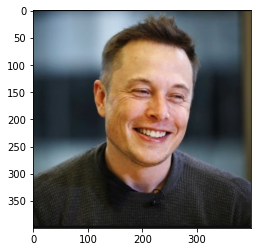

Esta imagem é de um humano e ele/ela se parece com  Afghan_hound




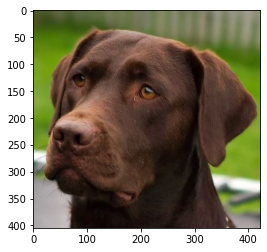

A imagem é de um cão e a raça é  Petit_basset_griffon_vendeen




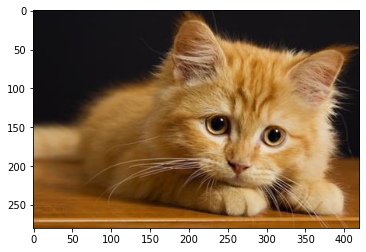

Não foi possível detectar se é um humano ou cão!




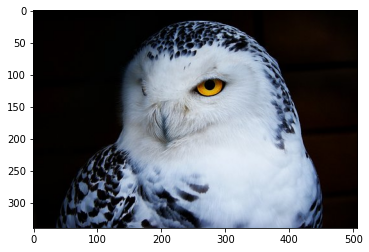

Não foi possível detectar se é um humano ou cão!




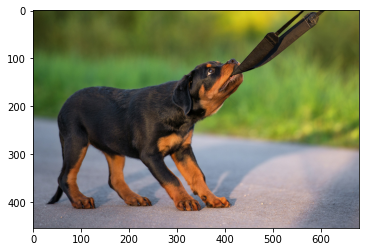

A imagem é de um cão e a raça é  Cairn_terrier




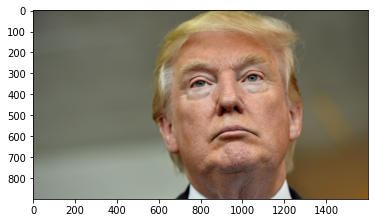

Esta imagem é de um humano e ele/ela se parece com  American_foxhound




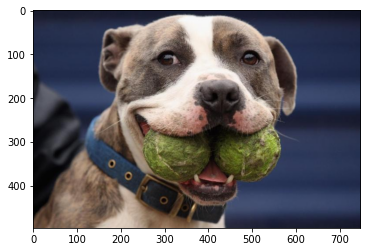

A imagem é de um cão e a raça é  Labrador_retriever




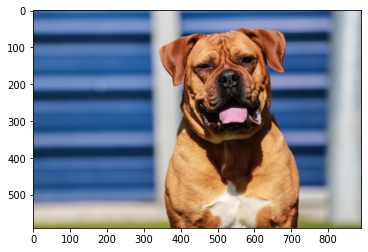

A imagem é de um cão e a raça é  Gordon_setter




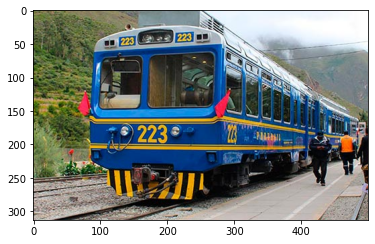

Não foi possível detectar se é um humano ou cão!




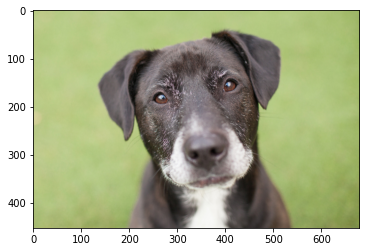

A imagem é de um cão e a raça é  Labrador_retriever




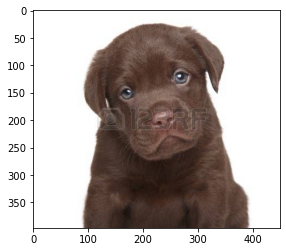

A imagem é de um cão e a raça é  Borzoi




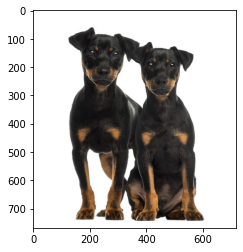

A imagem é de um cão e a raça é  Bull_terrier




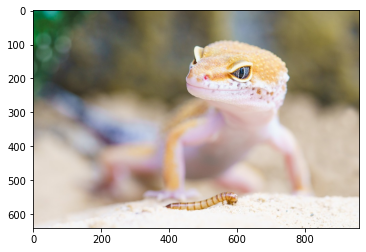

Não foi possível detectar se é um humano ou cão!




In [42]:
from os import listdir
from os.path import isfile, join
mypath = "./images_test"
onlyfiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
for path in onlyfiles:
    classifica_image(path)
    print ("")
    print ("")

# Fim